# Detecting Fake Human Face Images

INFO 251
Jonathan Chang Analysis

# Import Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.applications.densenet import DenseNet121
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn import metrics

# Load Data

Choose 1 of the options: Kaggle API or Google Drive mount

## With Google Drive

In [ ]:
# Read data from Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [ ]:
# if you get an error, pin the Info 251 Project folder in your Drive first
# (in Google Drive > Shared with Me > right click "Info 251 Project" > Add shortcut to Drive)
%cd /content/gdrive/MyDrive/Info 251 Project/
!ls

/content/gdrive/.shortcut-targets-by-id/1Agh2NXjOWlAXf-V8FKEdMK6L7JJa6t77/Info 251 Project
 A.Ibarra_Analysis.ipynb	       kaggle.json
 Alberto_model			       photoshop_dataset.zip
 Analysis_Work.ipynb		      'Project Write-Up.gdoc'
 data				       sample_code
 faces_data.zip			       test.csv
'Final Project Presentation.gslides'   test.zip
'Jared Analysis.ipynb'		       train.csv
 jared_model			      'valid (1).csv'
'JC Analysis Checkpoint1.ipynb'        valid.csv
'JC Analysis.ipynb'		       valid.zip
 jonathan_model


In [ ]:
# save the zip from GDrive to local VM (unzipped), takes ~1.5 min
!unzip faces_data.zip -d /content/

# set working directory to '/content'
%cd /content

## With Kaggle API

To use the Kaggle API, see loading datasets into Colab using Kaggle API: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

Will need to upload your Kaggle API keys, only need to do once. Uncomment code chunk below to run

In [ ]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# import kaggle
# !kaggle datasets download -d xhlulu/140k-real-and-fake-faces
# !unzip 140k-real-and-fake-faces.zip

# Print out examples

In [ ]:
# From the original 140k images, we use the 20k images found in the test folder
%cd /content
data= pd.read_csv('test.csv')
data.head()

/content


Unnamed: 0                                      original_path     id  \
0           0  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  18233   
1           1  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  54317   
2           2  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  40155   
3           3  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  12875   
4           4  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  52543   

   label label_str                 path  
0      1      real  test/real/18233.jpg  
1      1      real  test/real/54317.jpg  
2      1      real  test/real/40155.jpg  
3      1      real  test/real/12875.jpg  
4      1      real  test/real/52543.jpg

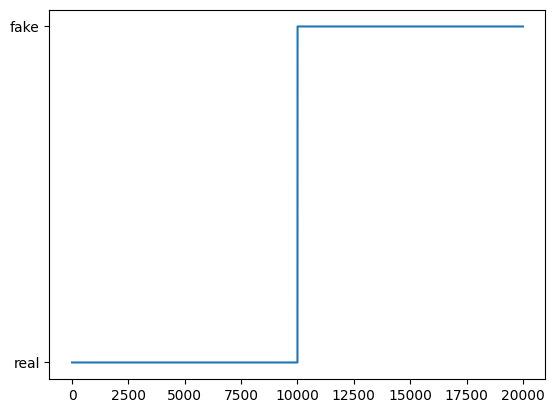

In [ ]:
plt.plot(data["label_str"])
plt.show()

In [ ]:
data.value_counts("label_str")

label_str
fake    10000
real    10000
dtype: int64

In [ ]:
!pwd
%cd real_vs_fake/real-vs-fake/test
path = !pwd
path = path[0]

workdir= os.listdir()
if '.DS_Store' in workdir:
   workdir.remove('.DS_Store')

workdir

/content
/content/real_vs_fake/real-vs-fake/test


['real', 'fake']

In [ ]:
dataset = {"image_path":[],"image_name":[],"image_folder":[]}
for folder in workdir:
    for name in os.listdir(folder):
          dataset["image_path"].append(os.getcwd()+ "/" + folder + "/" + name)
          dataset["image_name"].append(name)
          dataset["image_folder"].append(folder)
df = pd.DataFrame(dataset)
df

image_path      image_name  \
0      /content/real_vs_fake/real-vs-fake/test/real/1...       11860.jpg   
1      /content/real_vs_fake/real-vs-fake/test/real/3...       34028.jpg   
2      /content/real_vs_fake/real-vs-fake/test/real/0...       02019.jpg   
3      /content/real_vs_fake/real-vs-fake/test/real/3...       36219.jpg   
4      /content/real_vs_fake/real-vs-fake/test/real/4...       46550.jpg   
...                                                  ...             ...   
19995  /content/real_vs_fake/real-vs-fake/test/fake/N...  NLW38BAR8H.jpg   
19996  /content/real_vs_fake/real-vs-fake/test/fake/9...  92Z7LMYLLC.jpg   
19997  /content/real_vs_fake/real-vs-fake/test/fake/I...  IT244HWWWU.jpg   
19998  /content/real_vs_fake/real-vs-fake/test/fake/2...  2ZVLB4DEDZ.jpg   
19999  /content/real_vs_fake/real-vs-fake/test/fake/B...  BPH3978DWU.jpg   

      image_folder  
0             real  
1             real  
2             real  
3             real  
4             real  
...            ...  
19995         fake  
19996         fake  
19997         fake  
19998         fake  
19999         fake  

[20000 rows x 3 columns]

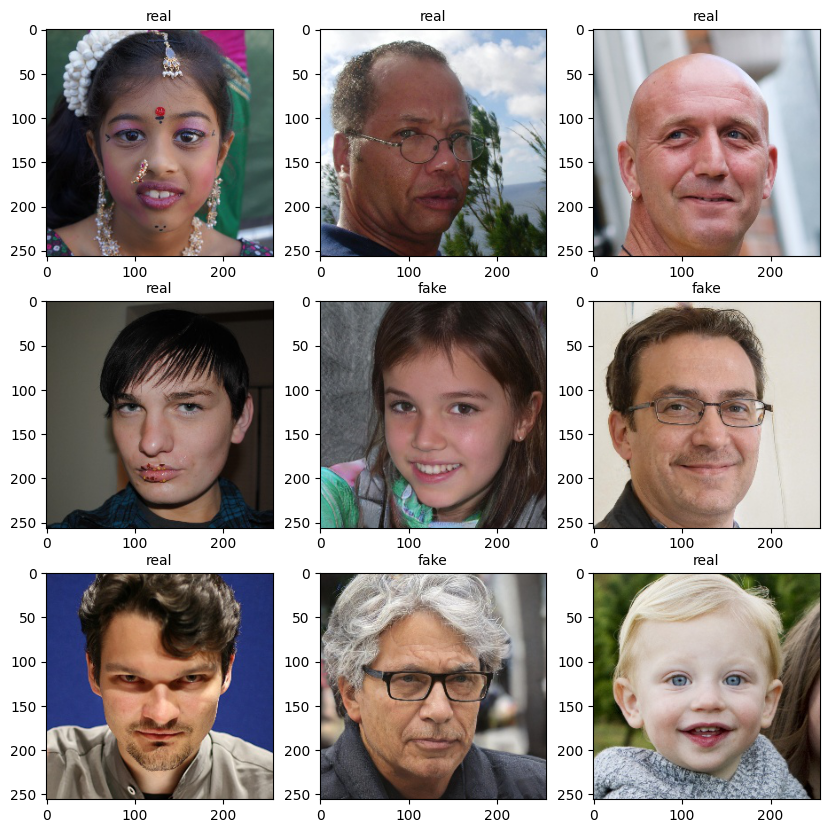

In [ ]:
plt.figure(figsize = (10,10))
for i in range(9):
    random = np.random.randint(1,len(df))
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(df.loc[random,"image_path"]))
    plt.title(df.loc[random, "image_folder"], size = 10) 
    
plt.show()

# Preprocess the images 
Using Kera's ImageDataGenerator function to create small batches of images, convert to grayscale, downsize images, and label binary classes (Fake / real) for the model. Split the 20k images -- 18k for training and 2k for validation

In [ ]:
# https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator 

path = !pwd
path = path[0]

image_gen = ImageDataGenerator(
    validation_split=0.1,
    rescale=1/255
)

train_generator = image_gen.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=25,
    color_mode='grayscale',
    class_mode ='binary',
    subset='training'
)

validation_generator = image_gen.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=25,
    color_mode='grayscale',
    class_mode ='binary',
    subset='validation')


Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# CNN model (DenseNet121 Architecture)

DenseNet-121 has 120 Convolutions and 4 AvgPool

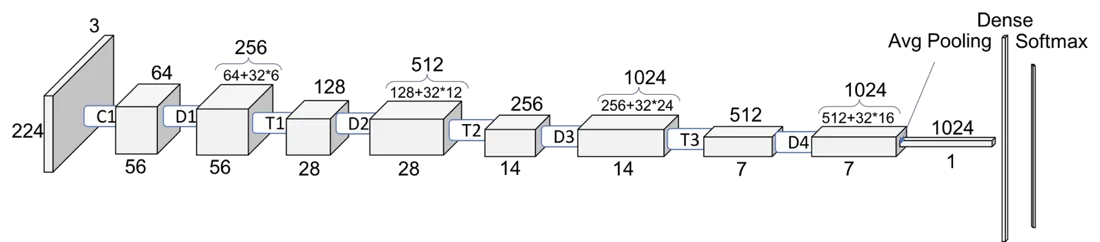

In [ ]:
densenet = DenseNet121( weights=None, include_top=False, input_shape=(128,128,1) )

model = keras.Sequential([ 
        densenet,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy', optimizer= Adam() , metrics=['accuracy'])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7031232   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 7,032,257
Trainable params: 6,948,609
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size, # 10,000 / 100
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size,
    epochs = 10
)

Epoch 1/10
720/720 [==============================] - 100s 121ms/step - loss: 0.6692 - accuracy: 0.6007 - val_loss: 0.6349 - val_accuracy: 0.6470
Epoch 2/10
720/720 [==============================] - 83s 115ms/step - loss: 0.5692 - accuracy: 0.7074 - val_loss: 0.6176 - val_accuracy: 0.6710
Epoch 3/10
720/720 [==============================] - 84s 116ms/step - loss: 0.5228 - accuracy: 0.7412 - val_loss: 0.9084 - val_accuracy: 0.5560
Epoch 4/10
720/720 [==============================] - 83s 115ms/step - loss: 0.4760 - accuracy: 0.7730 - val_loss: 1.0695 - val_accuracy: 0.5295
Epoch 5/10
720/720 [==============================] - 84s 117ms/step - loss: 0.4287 - accuracy: 0.8022 - val_loss: 1.0610 - val_accuracy: 0.5415
Epoch 6/10
720/720 [==============================] - 84s 117ms/step - loss: 0.3882 - accuracy: 0.8264 - val_loss: 0.4834 - val_accuracy: 0.7905
Epoch 7/10
720/720 [==============================] - 85s 118ms/step - loss: 0.3396 - accuracy: 0.8504 - val_loss: 0.8520 - val_a

In [ ]:
model_hist = pd.DataFrame(model.history.history)
model_hist

loss  accuracy  val_loss  val_accuracy
0  0.669168  0.600667  0.634919        0.6470
1  0.569156  0.707444  0.617566        0.6710
2  0.522811  0.741222  0.908445        0.5560
3  0.475967  0.773000  1.069473        0.5295
4  0.428650  0.802167  1.060962        0.5415
5  0.388217  0.826444  0.483435        0.7905
6  0.339552  0.850389  0.851992        0.6670
7  0.296819  0.873278  0.466922        0.8075
8  0.251029  0.896778  0.399779        0.8260
9  0.214858  0.912444  0.457032        0.8195

Text(0.5, 1.0, 'Accuracy Per Epoch')

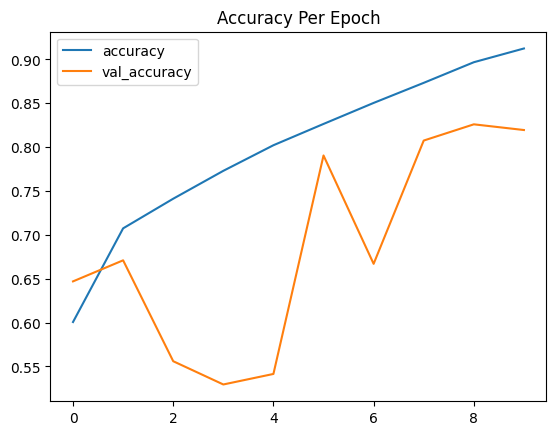

In [ ]:
model_hist[['accuracy','val_accuracy']].plot()
plt.title('Accuracy Per Epoch')

In [ ]:
model_hist[['loss','val_loss']].plot()
plt.title('Loss Per Epoch')

In [ ]:
# Save model for later
%cd /content
model.save('model1.h5')
%cd real_vs_fake/real-vs-fake/test

/content
/content/real_vs_fake/real-vs-fake/test


## Test Prediction

In [ ]:
# import model
# from tensorflow import keras
# model = keras.models.load_model('/content/gdrive/MyDrive/Info 251 Project/jonathan_model/model1.h5')

In [ ]:

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7031232   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 7,032,257
Trainable params: 6,948,609
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
# create the test generator

path = '/content/real_vs_fake/real-vs-fake/valid'

image_gen_test = ImageDataGenerator(
    validation_split=0.1
)

throwaway_generator = image_gen_test.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=25,
    color_mode='grayscale',
    class_mode ='binary',
    shuffle=False,
    subset='training'
)

test_generator = image_gen_test.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=1,
    color_mode='grayscale',
    class_mode ='binary',
    shuffle= False,
    subset='validation')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
y_pred = model.predict(test_generator)
y_test = test_generator.classes

2000/2000 [==============================] - 28s 14ms/step


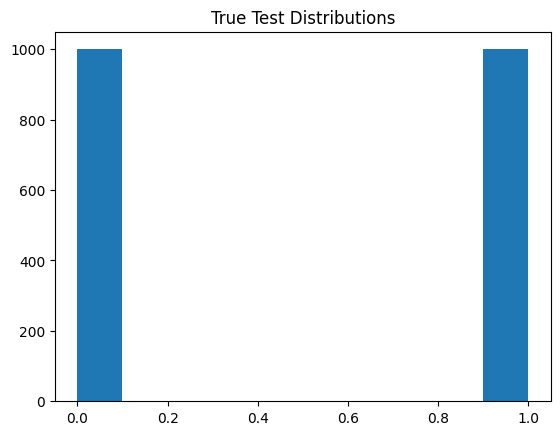

In [ ]:
plt.hist(y_test)
plt.title('True Test Distributions')
plt.show()

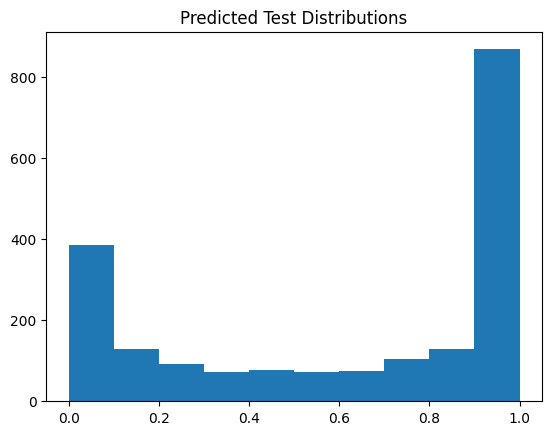

In [ ]:
plt.hist(y_pred)
plt.title('Predicted Test Distributions')
plt.show()

In [ ]:
print(metrics.classification_report(y_test, y_pred > 0.5, target_names=['fake', 'real']))

              precision    recall  f1-score   support

           0       0.92      0.69      0.79      1000
           1       0.76      0.94      0.84      1000

    accuracy                           0.82      2000
   macro avg       0.84      0.82      0.82      2000
weighted avg       0.84      0.82      0.82      2000



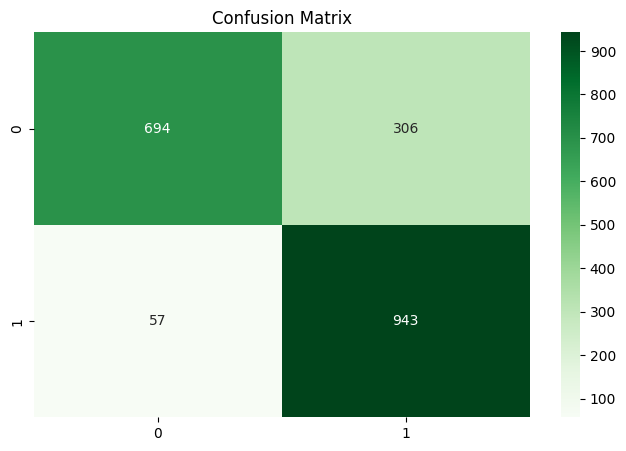

In [ ]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot = True,fmt="d",cmap = "Greens")
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

ROC-AUC Score: 0.9197850000000002
AP Score: 0.9106605711072006


# Model Tuning 

## Effect of increased Image size 
256x256 px vs 128x128


In [ ]:

image_gen = ImageDataGenerator(
    validation_split=0.1
)

train_generator = image_gen.flow_from_directory(
    path,
    target_size=(256, 256),
    batch_size=25,
    color_mode='grayscale',
    class_mode ='binary',
    #classes=['fake','real'],
    subset='training'
)

validation_generator = image_gen.flow_from_directory(
    path,
    target_size=(256, 256),
    batch_size=25,
    color_mode='grayscale',
    class_mode ='binary',
    #classes=['fake','real'],
    subset='validation')

densenet = DenseNet121( weights=None, include_top=False, input_shape=(256,256,1) )

model = keras.Sequential([ 
        densenet,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy', optimizer= Adam() , metrics=['accuracy'])

model.summary()

history256 = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size, # 10,000 / 100
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size,
    epochs = 10
)


Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7031232   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,032,257
Trainable params: 6,948,609
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/10
720/720 [==============================] - 269s 336ms/step - loss: 0.6820 - accuracy: 0.5778 - val_loss: 0.6803 - val_accuracy: 0.5495
Epoch 2/

/content
/content/real_vs_fake/real-vs-fake/test


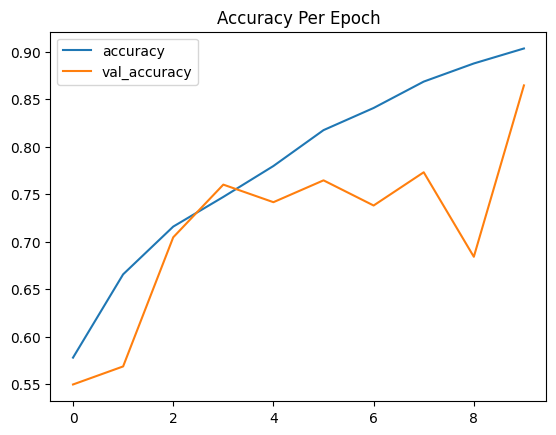

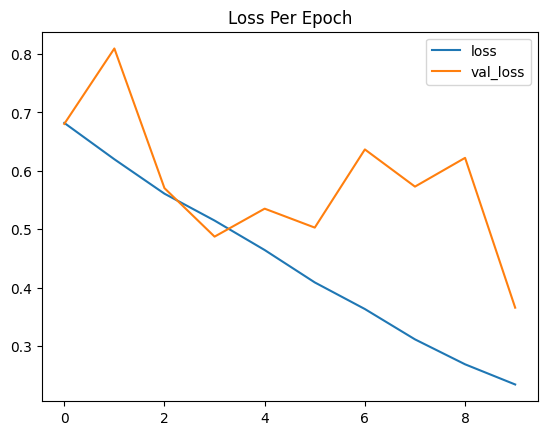

In [ ]:
model_hist256 = pd.DataFrame(model.history.history)
model_hist256

model_hist256[['accuracy','val_accuracy']].plot()
plt.title('Accuracy Per Epoch')

model_hist256[['loss','val_loss']].plot()
plt.title('Loss Per Epoch')

%cd /content
model.save('model2_10.h5')
%cd real_vs_fake/real-vs-fake/test


In [ ]:
# create the test generator

path = '/content/real_vs_fake/real-vs-fake/valid'

image_gen_test = ImageDataGenerator(
    validation_split=0.1
)

throwaway_generator = image_gen_test.flow_from_directory(
    path,
    target_size=(256, 256),
    batch_size=25,
    color_mode='grayscale',
    class_mode ='binary',
    subset='training'
)

test_generator = image_gen_test.flow_from_directory(
    path,
    target_size=(256, 256),
    batch_size=25,
    color_mode='grayscale',
    class_mode ='binary',
    shuffle = False,
    subset='validation')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
y_pred = model.predict(test_generator)
y_test = test_generator.classes

80/80 [==============================] - 9s 95ms/step


In [ ]:
# fake is 0, real is 1
train_generator.class_indices, test_generator.class_indices

({'fake': 0, 'real': 1}, {'fake': 0, 'real': 1}, {'fake': 0, 'real': 1})

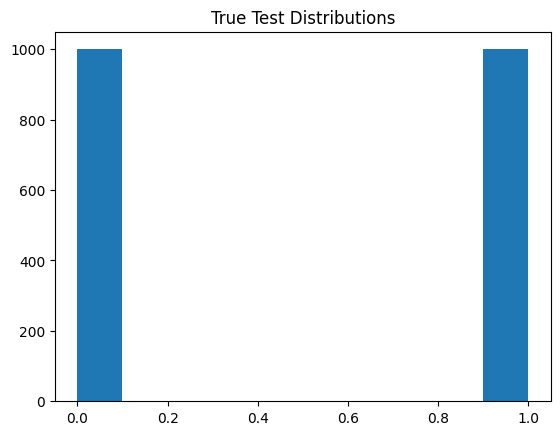

In [ ]:
plt.hist(y_test)
plt.title('True Test Distributions')
plt.show()

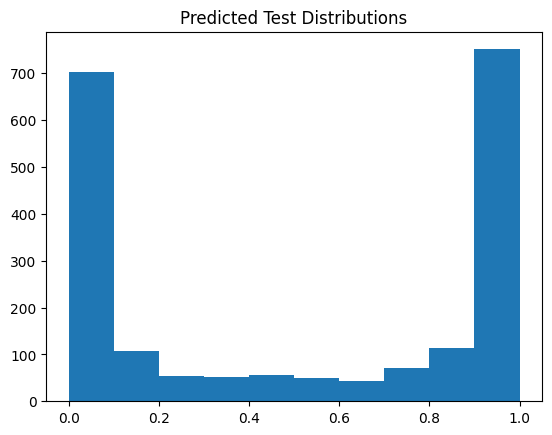

In [ ]:
plt.hist(y_pred)
plt.title('Predicted Test Distributions')
plt.show()

In [ ]:
print(metrics.classification_report(y_test, y_pred > 0.5, target_names=['fake', 'real']))

              precision    recall  f1-score   support

        fake       0.89      0.86      0.87      1000
        real       0.87      0.89      0.88      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



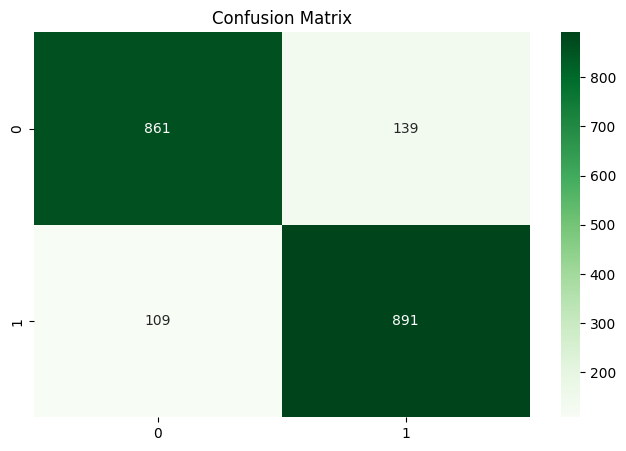

In [ ]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot = True,fmt="d",cmap = "Greens")
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

ROC-AUC Score: 0.9442809999999999
AP Score: 0.9373710119833106


## Effect of Color

In [ ]:
image_gen = ImageDataGenerator(
    validation_split=0.1,
    rescale=1/255
)

train_generator = image_gen.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=25,
    class_mode ='binary',
    subset='training'
)

validation_generator = image_gen.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=25,
    class_mode ='binary',
    subset='validation')


Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
densenet = DenseNet121( weights=None, include_top=False, input_shape=(128,128,3) )

model = keras.Sequential([ 
        densenet,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy', optimizer= Adam() , metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size, # 10,000 / 100
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size,
    epochs = 10
)

%cd /content
model.save('model_color_10.h5')

Epoch 1/10
720/720 [==============================] - 102s 122ms/step - loss: 0.6825 - accuracy: 0.5841 - val_loss: 0.8859 - val_accuracy: 0.4980
Epoch 2/10
720/720 [==============================] - 85s 119ms/step - loss: 0.5893 - accuracy: 0.6888 - val_loss: 1.1487 - val_accuracy: 0.5035
Epoch 3/10
720/720 [==============================] - 85s 118ms/step - loss: 0.5152 - accuracy: 0.7495 - val_loss: 0.6828 - val_accuracy: 0.6325
Epoch 4/10
720/720 [==============================] - 88s 122ms/step - loss: 0.4565 - accuracy: 0.7872 - val_loss: 0.8060 - val_accuracy: 0.6425
Epoch 5/10
720/720 [==============================] - 85s 118ms/step - loss: 0.4094 - accuracy: 0.8126 - val_loss: 0.4748 - val_accuracy: 0.7850
Epoch 6/10
720/720 [==============================] - 85s 119ms/step - loss: 0.3675 - accuracy: 0.8362 - val_loss: 0.4730 - val_accuracy: 0.7800
Epoch 7/10
720/720 [==============================] - 85s 119ms/step - loss: 0.3220 - accuracy: 0.8618 - val_loss: 0.4938 - val_a

Text(0.5, 1.0, 'Loss Per Epoch')

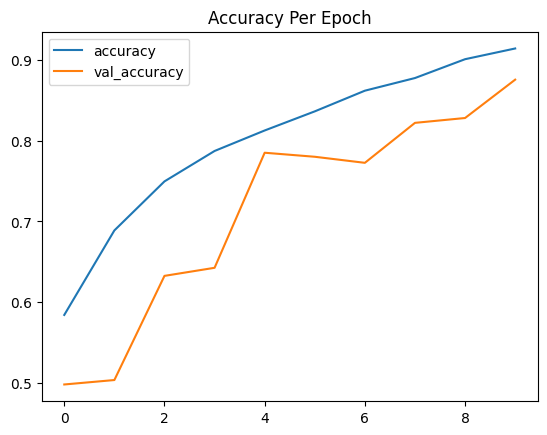

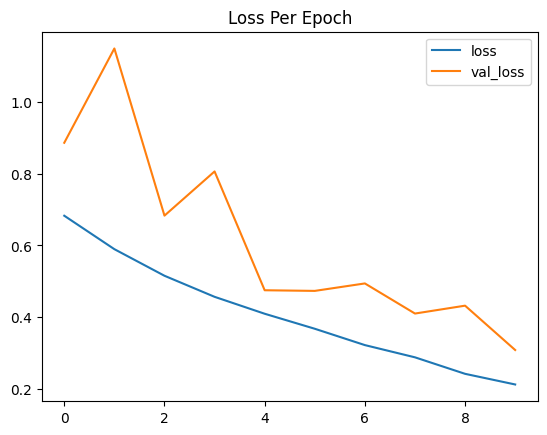

In [ ]:
model_hist= pd.DataFrame(model.history.history)
model_hist

model_hist[['accuracy','val_accuracy']].plot()
plt.title('Accuracy Per Epoch')

model_hist[['loss','val_loss']].plot()
plt.title('Loss Per Epoch')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
80/80 [==============================] - 8s 70ms/step
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1000
           1       0.89      0.86      0.87      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



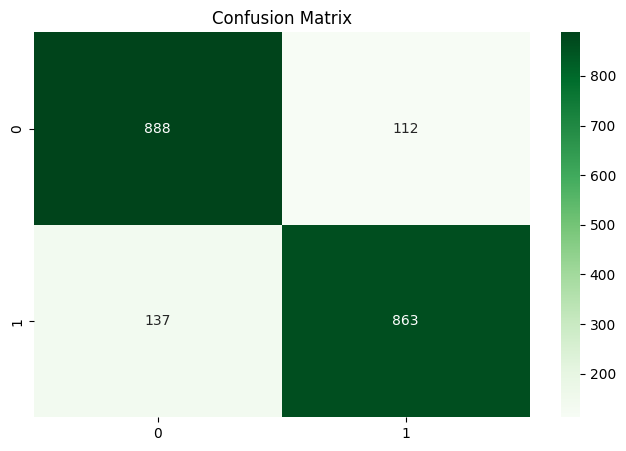

ROC-AUC Score: 0.946383
AP Score: 0.9429287691585198


In [ ]:
path = '/content/real_vs_fake/real-vs-fake/valid'

image_gen_test = ImageDataGenerator(
    validation_split=0.1,
    rescale=1/255
)

throwaway_generator = image_gen_test.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=25,
    class_mode ='binary',
    subset='training'
)

test_generator = image_gen_test.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=25,
    class_mode ='binary',
    shuffle = False,
    subset='validation')

y_pred = model.predict(test_generator)
y_test = test_generator.classes

print(metrics.classification_report(y_test, y_pred > 0.5, target_names=['fake', 'real']))

plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot = True,fmt="d",cmap = "Greens")
plt.title('Confusion Matrix')
plt.show()

print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

## Pretrained Densenet121 w/ ImageNet

In [ ]:
densenet = DenseNet121( weights="imagenet", include_top=False, input_shape=(128,128,3) )

model = keras.Sequential([ 
        densenet,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy', optimizer= Adam() , metrics=['accuracy'])


model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d_5   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_17 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
image_gen = ImageDataGenerator(
    validation_split=0.1,
    rescale=1/255
)

train_generator = image_gen.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=25,
    class_mode ='binary',
    subset='training'
)

validation_generator = image_gen.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=25,
    class_mode ='binary',
    #classes=['fake','real'],
    subset='validation')


Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size, # 10,000 / 100
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size,
    epochs = 10
)

%cd /content
model.save('model_imagenet_10.h5')

Epoch 1/10
720/720 [==============================] - 105s 127ms/step - loss: 0.4588 - accuracy: 0.7853 - val_loss: 1.1448 - val_accuracy: 0.5330
Epoch 2/10
720/720 [==============================] - 86s 120ms/step - loss: 0.2889 - accuracy: 0.8777 - val_loss: 0.8030 - val_accuracy: 0.7300
Epoch 3/10
720/720 [==============================] - 85s 118ms/step - loss: 0.1907 - accuracy: 0.9243 - val_loss: 0.4297 - val_accuracy: 0.8505
Epoch 4/10
720/720 [==============================] - 85s 118ms/step - loss: 0.1421 - accuracy: 0.9447 - val_loss: 0.5697 - val_accuracy: 0.8025
Epoch 5/10
720/720 [==============================] - 86s 120ms/step - loss: 0.1162 - accuracy: 0.9567 - val_loss: 0.1949 - val_accuracy: 0.9260
Epoch 6/10
720/720 [==============================] - 85s 118ms/step - loss: 0.0948 - accuracy: 0.9644 - val_loss: 0.2424 - val_accuracy: 0.9065
Epoch 7/10
720/720 [==============================] - 85s 118ms/step - loss: 0.0800 - accuracy: 0.9693 - val_loss: 0.1803 - val_a

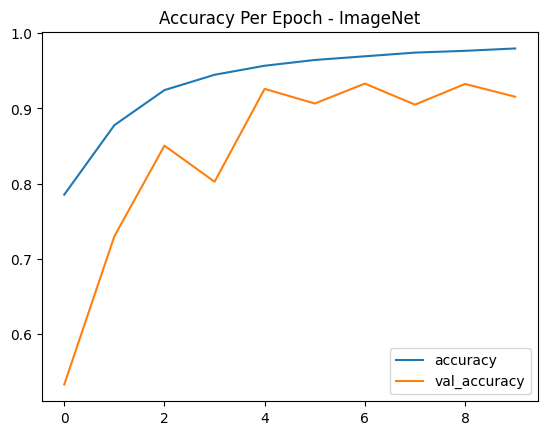

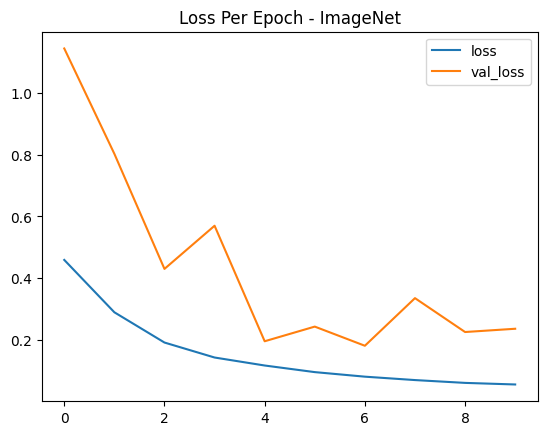

In [ ]:
model_hist_imagenet= pd.DataFrame(model.history.history)
model_hist_imagenet

model_hist_imagenet[['accuracy','val_accuracy']].plot()
plt.title('Accuracy Per Epoch - ImageNet')

model_hist_imagenet[['loss','val_loss']].plot()
plt.title('Loss Per Epoch - ImageNet')

plt.show()

In [ ]:
path = '/content/real_vs_fake/real-vs-fake/valid'

image_gen_test = ImageDataGenerator(
    validation_split=0.1,
    rescale=1/255
)

throwaway_generator = image_gen_test.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=25,
    class_mode ='binary',
    subset='training'
)

test_generator = image_gen_test.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=25,
    class_mode ='binary',
    shuffle = False,
    subset='validation')

y_pred = model.predict(test_generator)
y_test = test_generator.classes

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
80/80 [==============================] - 9s 103ms/step


In [ ]:
print(metrics.classification_report(y_test, y_pred > 0.5, target_names=['fake', 'real']))

              precision    recall  f1-score   support

        fake       0.92      0.95      0.93      1000
        real       0.95      0.91      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



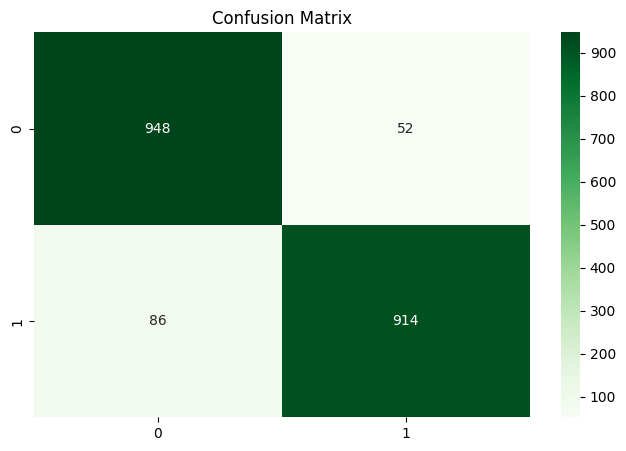

ROC-AUC Score: 0.980759
AP Score: 0.9802147027544307


In [ ]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot = True,fmt="d",cmap = "Greens")
plt.title('Confusion Matrix')
plt.show()

print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

# Checking misclassified images

In [ ]:
incorrect = (y_test != y_pred.flatten().round())
len(incorrect[incorrect == True])

138

In [ ]:
incorrect_indices = np.where(incorrect == True)
incorrect_indices

(array([  24,   40,   57,   60,   61,  142,  145,  188,  195,  203,  244,
         257,  280,  285,  304,  316,  325,  352,  368,  377,  378,  379,
         388,  402,  453,  481,  513,  535,  573,  578,  610,  619,  621,
         662,  675,  679,  707,  726,  748,  749,  750,  752,  767,  788,
         791,  807,  830,  896,  904,  911,  923,  977, 1009, 1036, 1039,
        1043, 1063, 1064, 1090, 1096, 1104, 1106, 1128, 1137, 1155, 1162,
        1185, 1187, 1228, 1260, 1263, 1265, 1281, 1329, 1349, 1370, 1392,
        1415, 1416, 1420, 1422, 1426, 1470, 1477, 1483, 1502, 1510, 1518,
        1529, 1532, 1537, 1562, 1569, 1572, 1576, 1588, 1612, 1618, 1626,
        1634, 1639, 1645, 1665, 1667, 1688, 1690, 1697, 1711, 1743, 1748,
        1756, 1762, 1782, 1801, 1802, 1803, 1808, 1824, 1832, 1834, 1838,
        1854, 1859, 1867, 1874, 1877, 1900, 1903, 1920, 1926, 1927, 1939,
        1948, 1960, 1970, 1980, 1981, 1983]),)

In [ ]:
# get the incorrect file names
test_files = test_generator.filenames
incorrect_files = [test_files[i] for i in incorrect_indices[0]]
incorrect_files[0]

'fake/03D9RYN433.jpg'

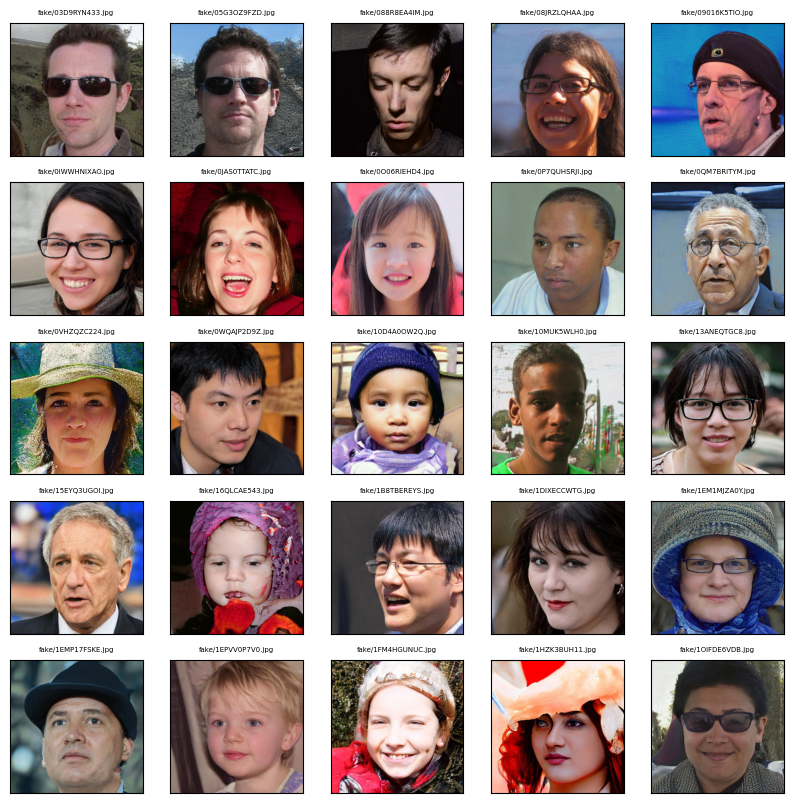

In [ ]:
# Plot the incorrectly classified files
plt.figure(figsize = (10,10))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(plt.imread('/content/real_vs_fake/real-vs-fake/valid/' + incorrect_files[i]))
    plt.title(incorrect_files[i], size = 5) 
    plt.xticks([])
    plt.yticks([])

plt.show()

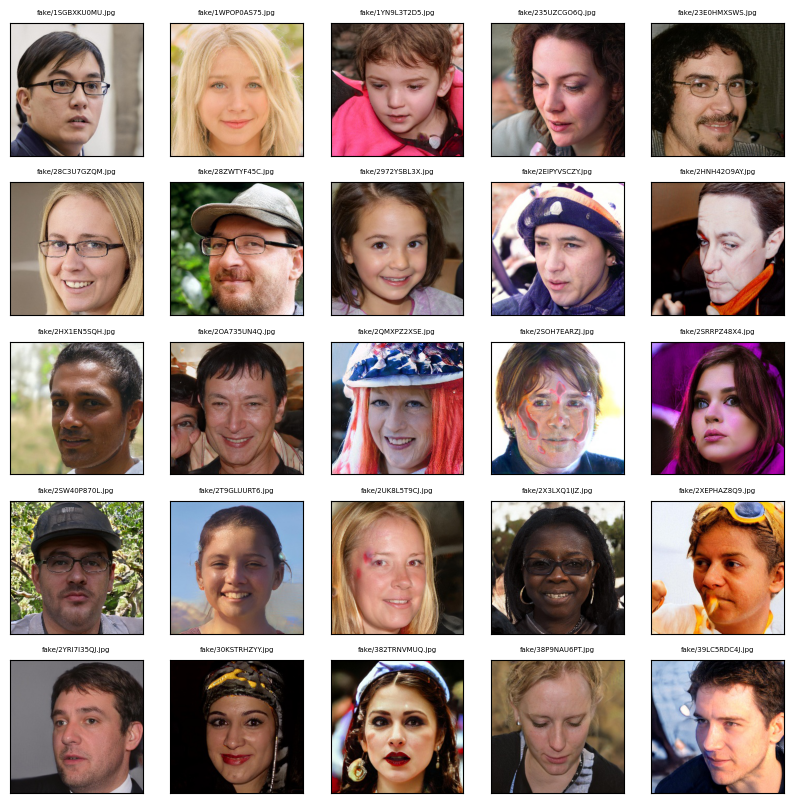

In [ ]:
plt.figure(figsize = (10,10))
for i in range(25,50):
    plt.subplot(5,5,i+1-25)
    plt.imshow(plt.imread('/content/real_vs_fake/real-vs-fake/valid/' + incorrect_files[i]))
    plt.title(incorrect_files[i], size = 5) 
    plt.xticks([])
    plt.yticks([])

plt.show()

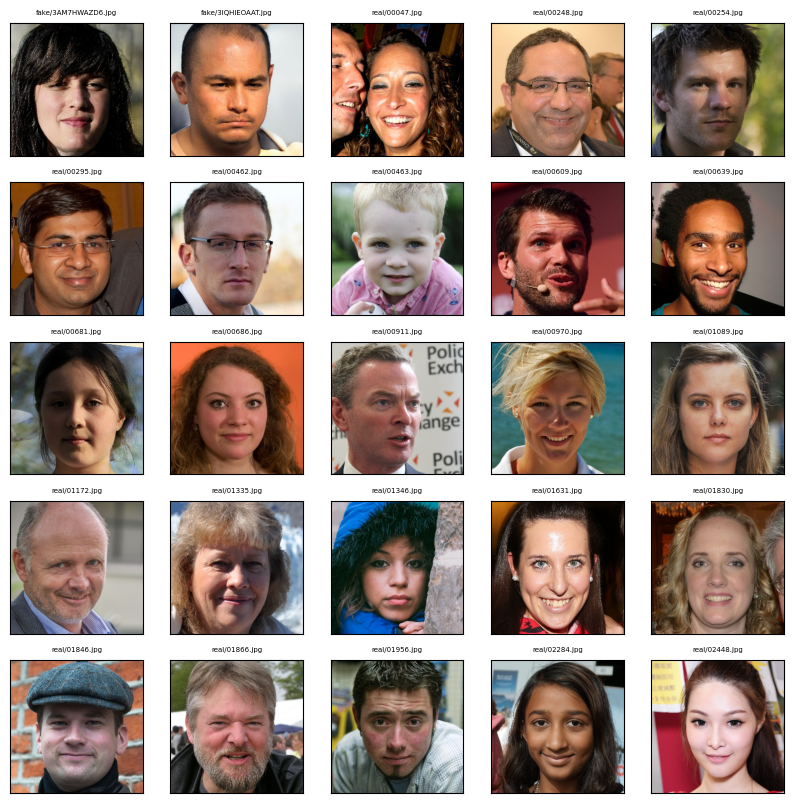

In [ ]:
plt.figure(figsize = (10,10))
for i in range(50,75):
    plt.subplot(5,5,i+1-50)
    plt.imshow(plt.imread('/content/real_vs_fake/real-vs-fake/valid/' + incorrect_files[i]))
    plt.title(incorrect_files[i], size = 5) 
    plt.xticks([])
    plt.yticks([])

plt.show()

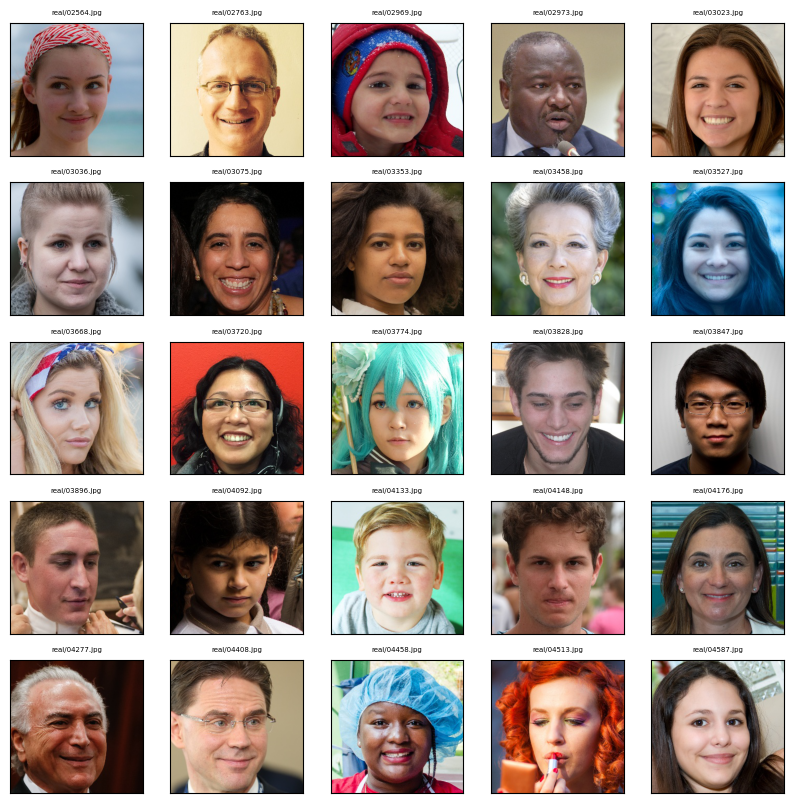

In [ ]:
plt.figure(figsize = (10,10))
for i in range(75,100):
    plt.subplot(5,5,i+1-75)
    plt.imshow(plt.imread('/content/real_vs_fake/real-vs-fake/valid/' + incorrect_files[i]))
    plt.title(incorrect_files[i], size = 5) 
    plt.xticks([])
    plt.yticks([])

plt.show()

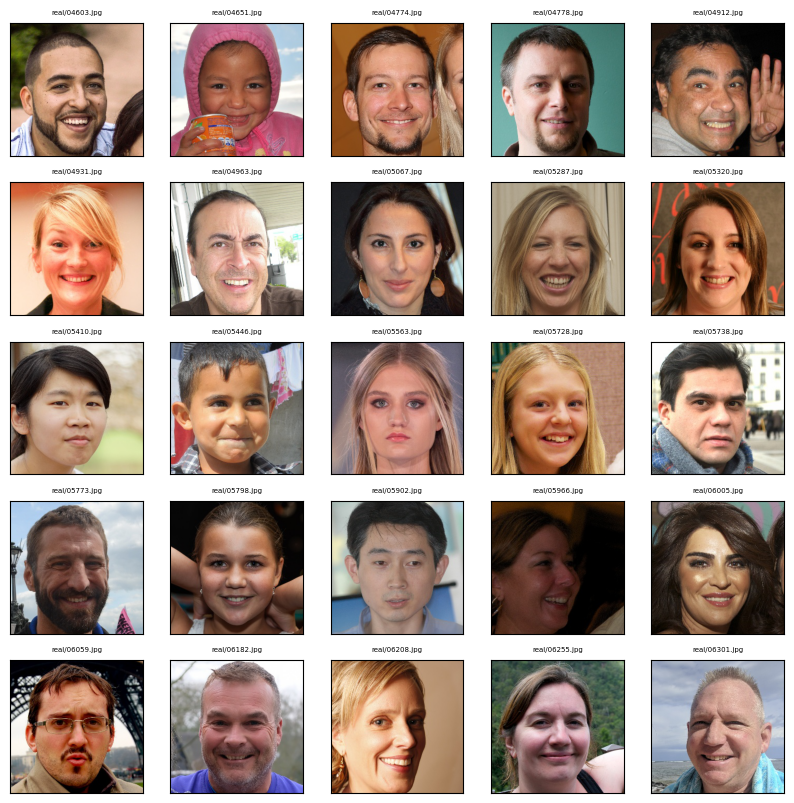

In [ ]:
plt.figure(figsize = (10,10))
for i in range(100,125):
    plt.subplot(5,5,i+1-100)
    plt.imshow(plt.imread('/content/real_vs_fake/real-vs-fake/valid/' + incorrect_files[i]))
    plt.title(incorrect_files[i], size = 5) 
    plt.xticks([])
    plt.yticks([])

plt.show()

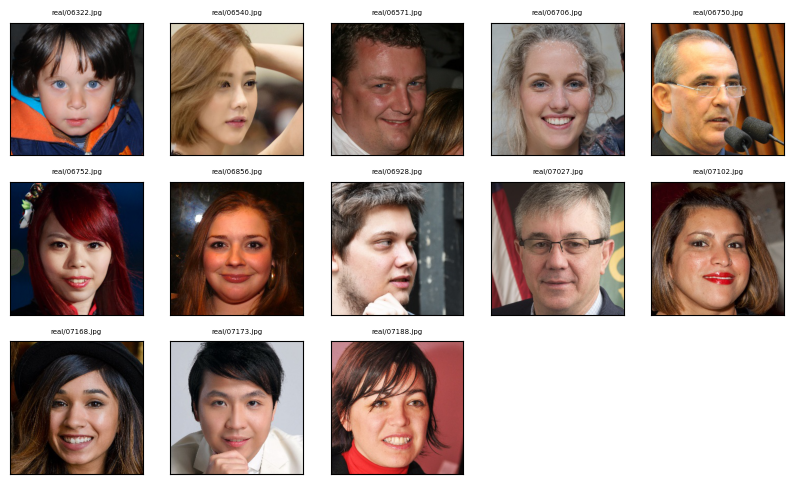

In [ ]:
plt.figure(figsize = (10,10))
for i in range(125,138):
    plt.subplot(5,5,i+1-125)
    plt.imshow(plt.imread('/content/real_vs_fake/real-vs-fake/valid/' + incorrect_files[i]))
    plt.title(incorrect_files[i], size = 5) 
    plt.xticks([])
    plt.yticks([])

plt.show()

# Model Generalizability
Testing on other types of image manipulation (Photoshopped data). Not the focus of our project but we're curious about about how well this generalizes.

In [ ]:
# Unzip the Photoshop Dataset
%cd /content/gdrive/MyDrive/Info 251 Project/
!ls
!unzip photoshop_dataset.zip -d /content/

%cd /content/real_and_fake_face

In [ ]:
# Or use Kaggle; uncomment below if you want to use this option

# kaggle datasets download -d ciplab/real-and-fake-face-detection
# !unzip real-and-fake-face-detection.zip

## Test on ImageNet Model on Photoshop data


In [ ]:
model = keras.models.load_model('/content/gdrive/MyDrive/Info 251 Project/jonathan_model/model_imagenet.h5')

Found 2041 images belonging to 2 classes.
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_12 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________
82/82 [==============================] - 23s 282ms/step
              precision    recall  f1-score   support

        fake       0.47      1.00      0.64       960
        real       0.00      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


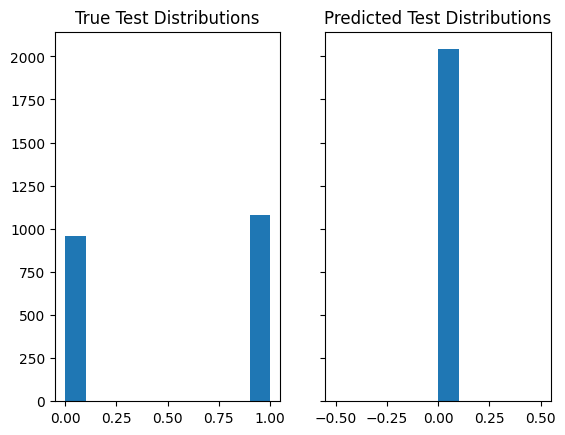

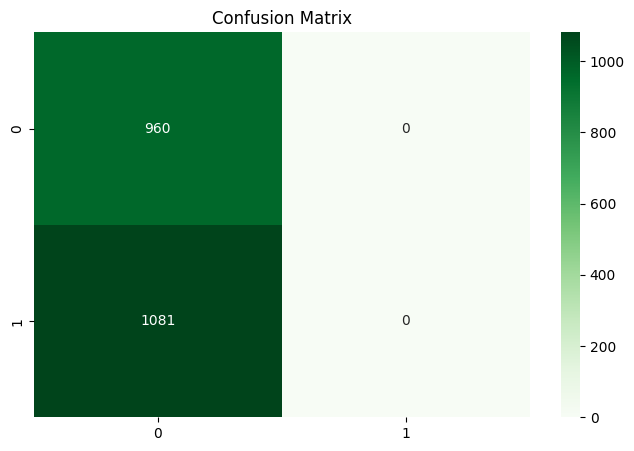

ROC-AUC Score: 0.5
AP Score: 0.5296423321901029


In [ ]:
path = '/content/real_and_fake_face_detection/real_and_fake_face'

image_gen_test = ImageDataGenerator()

test_generator = image_gen_test.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=25,
    class_mode ='binary',
    shuffle = False)

model.summary()

y_pred = model.predict(test_generator)
y_test = test_generator.classes

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(y_test)
ax1.set_title('True Test Distributions')

ax2.hist(y_pred)
ax2.set_title('Predicted Test Distributions')

print(metrics.classification_report(y_test, y_pred > 0.5, target_names=['fake', 'real']))

plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot = True,fmt="d",cmap = "Greens")
plt.title('Confusion Matrix')
plt.show()

print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

## Testing Photoshopped Trained Model on GAN data

In [ ]:
# train CNN on photoshop data

path = '/content/real_and_fake_face'

image_gen = ImageDataGenerator(
    validation_split=0.2
)

train_generator = image_gen.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=25,
    color_mode='grayscale',
    class_mode ='binary',
    #classes=['fake','real'],
    subset='training'
)

validation_generator = image_gen.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=25,
    color_mode='grayscale',
    class_mode ='binary',
    #classes=['fake','real'],
    subset='validation')

densenet = DenseNet121( weights=None, include_top=False, input_shape=(128,128,1) )

model = keras.Sequential([ 
        densenet,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy', optimizer= Adam() , metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size, # 10,000 / 100
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size,
    epochs = 10
)

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7031232   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 7,032,257
Trainable params: 6,948,609
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/10
65/65 [==============================] - 45s 503ms/step - loss: 0.7806 - accuracy: 0.4863 - val_loss: 12.5739 - val_accuracy: 0.5275
Epoch 2/10

In [ ]:
# save CNN trained on photoshop
%cd /content
model.save('model3.h5')

/content


Text(0.5, 1.0, 'Loss Per Epoch')

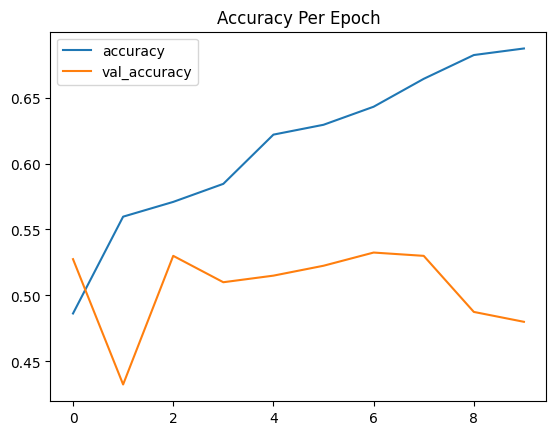

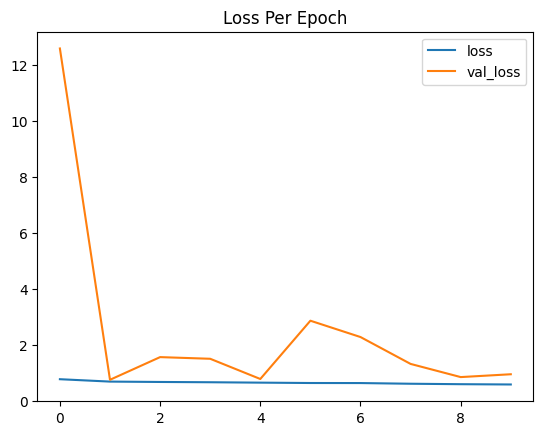

In [ ]:
model_ps_hist = pd.DataFrame(model.history.history)
model_ps_hist

model_ps_hist[['accuracy','val_accuracy']].plot()
plt.title('Accuracy Per Epoch')

model_ps_hist[['loss','val_loss']].plot()
plt.title('Loss Per Epoch')

In [ ]:

# create the test generator

path = '/content/real_vs_fake/real-vs-fake/valid'

image_gen_test = ImageDataGenerator(
    validation_split=0.1
)

throwaway_generator = image_gen_test.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=25,
    color_mode='grayscale',
    class_mode ='binary',
    shuffle=False,
    subset='training'
)

test_generator = image_gen_test.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=1,
    color_mode='grayscale',
    class_mode ='binary',
    shuffle= False,
    subset='validation')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
y_pred = model.predict(test_generator)
y_test = test_generator.classes



2000/2000 [==============================] - 45s 21ms/step


              precision    recall  f1-score   support

           0       0.54      0.24      0.34      1000
           1       0.51      0.79      0.62      1000

    accuracy                           0.52      2000
   macro avg       0.53      0.52      0.48      2000
weighted avg       0.53      0.52      0.48      2000



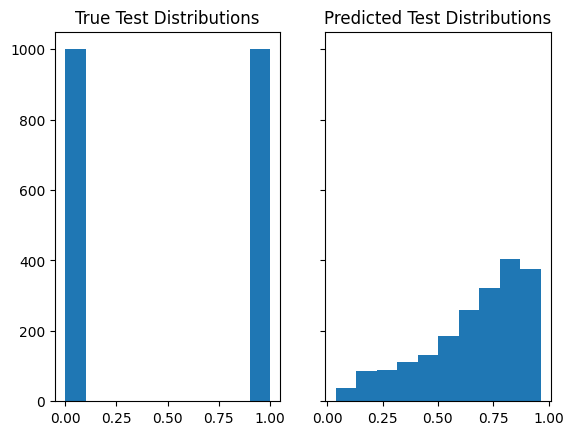

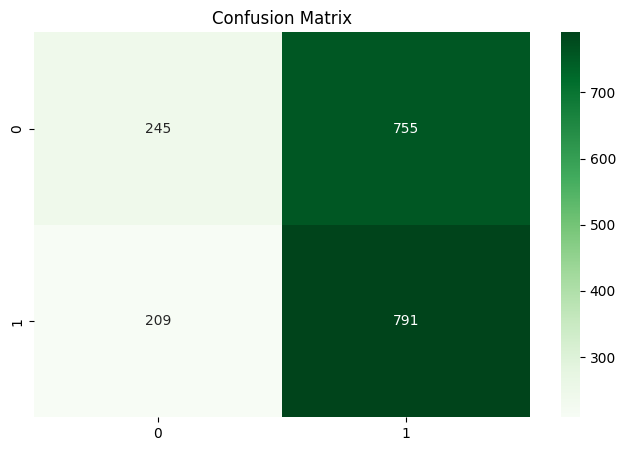

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(y_test)
ax1.set_title('True Test Distributions')

ax2.hist(y_pred)
ax2.set_title('Predicted Test Distributions')

print(metrics.classification_report(y_test, y_pred > 0.5, target_names=['fake', 'real']))

plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot = True,fmt="d",cmap = "Greens")
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

ROC-AUC Score: 0.533361
AP Score: 0.5400440928296886
